This notebook was made with reference from this kaggle notebook: https://www.kaggle.com/code/prasadiw/time-series-forecasting-stock-prices

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
df_log = pd.read_csv("./data/processed/mastercard_stock_history_processed.csv")

df_log["Date"] = pd.to_datetime(df_log['Date'])
df_log.set_index('Date', inplace = True)
df_log.head()

,Close
Date,
2006-05-25,1.453770
2006-05-26,1.430235
2006-05-30,1.409318
2006-05-31,1.430457
2006-06-01,1.486069


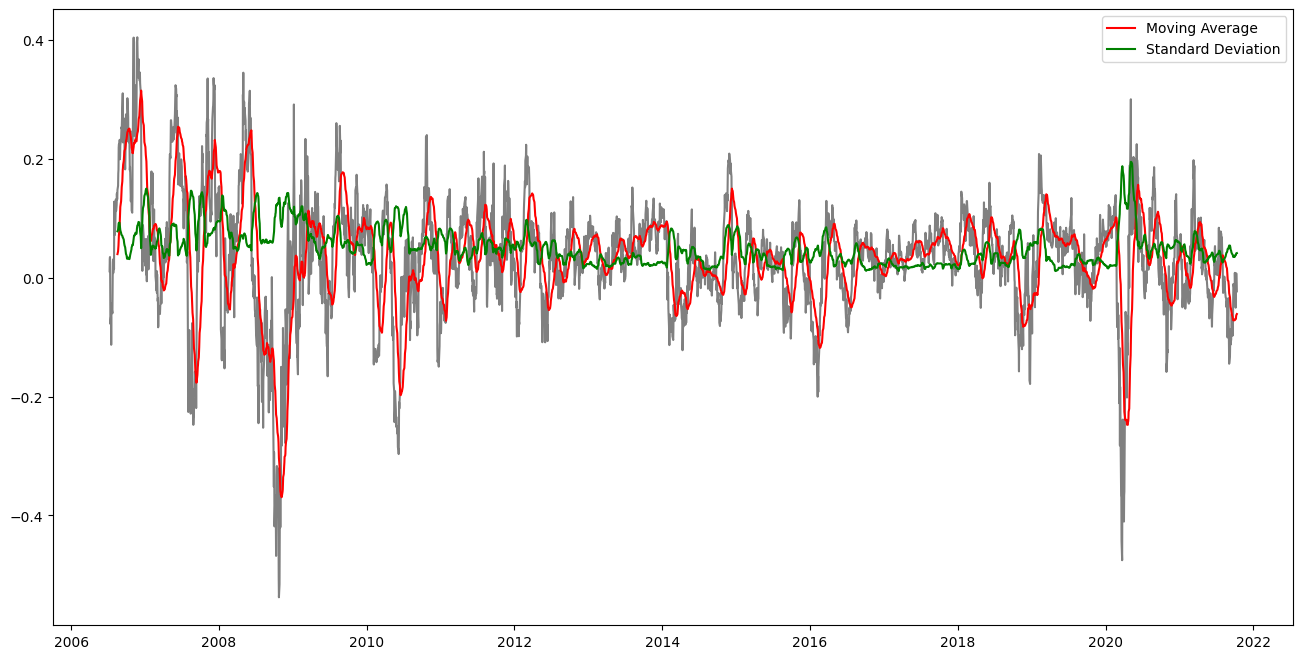

In [2]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 30)
MAvg_shift = df_shift.rolling(window=30).mean()
MStd_shift = df_shift.rolling(window=30).std()
plt.plot(df_shift, color='grey')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

# Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

<Figure size 1800x800 with 0 Axes>

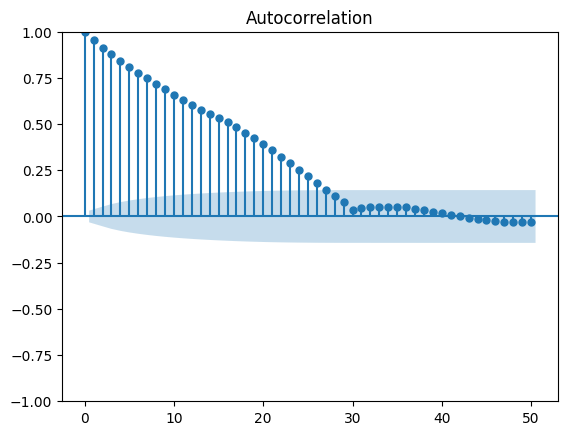

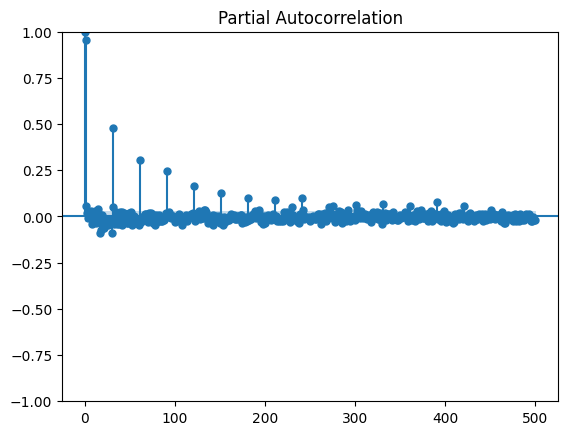

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(18, 8))
plot_acf(df_shift, lags = 50)
plot_pacf(df_shift, lags = 500)
plt.show()

In [4]:
df_shift.head()

,Close
Date,
2006-07-10,0.010596
2006-07-11,0.031115
2006-07-12,0.034621
2006-07-13,-0.004908
2006-07-14,-0.077888


From the graph, we can try:
1. p = 415 (highest lag that falls outside the statistically significant boundary in the PACF plot is around 415, due to the sparsely decreasing trend of $corr(x, x_t)$ as $t \to \infty$)
2. q = 26 (highest lag falling outside statistically significant boundary in ACF plot is 26)
3. d = 0 (We have determined via ADF that the time series is stationary)

## Splitting of data into train and test sets

In [5]:
# code to find out the date at the 80th percentile of the dataframe
train_end_id = round((len(df_shift) - 1) * 0.8)
test_start_id = train_end_id + 1


In [6]:
orig_df_train = df_log.iloc[:test_start_id]
orig_df_test = df_log.iloc[test_start_id:]
df_train = df_shift.iloc[:test_start_id] # because iloc is exclusive
df_test = df_shift.iloc[test_start_id:]
print(df_train)
print(df_test)

               Close
Date                
2006-07-10  0.010596
2006-07-11  0.031115
2006-07-12  0.034621
2006-07-13 -0.004908
2006-07-14 -0.077888
...              ...
2018-09-17  0.073153
2018-09-18  0.087867
2018-09-19  0.074034
2018-09-20  0.087410
2018-09-21  0.086070

[3074 rows x 1 columns]
               Close
Date                
2018-09-24  0.088265
2018-09-25  0.093416
2018-09-26  0.086316
2018-09-27  0.104556
2018-09-28  0.089264
...              ...
2021-10-05 -0.050563
2021-10-06 -0.036853
2021-10-07 -0.013296
2021-10-08  0.007196
2021-10-11 -0.023152

[768 rows x 1 columns]


## AR Model

Fitting and predict the shifted series with the AR Model and calculate the RMSE.

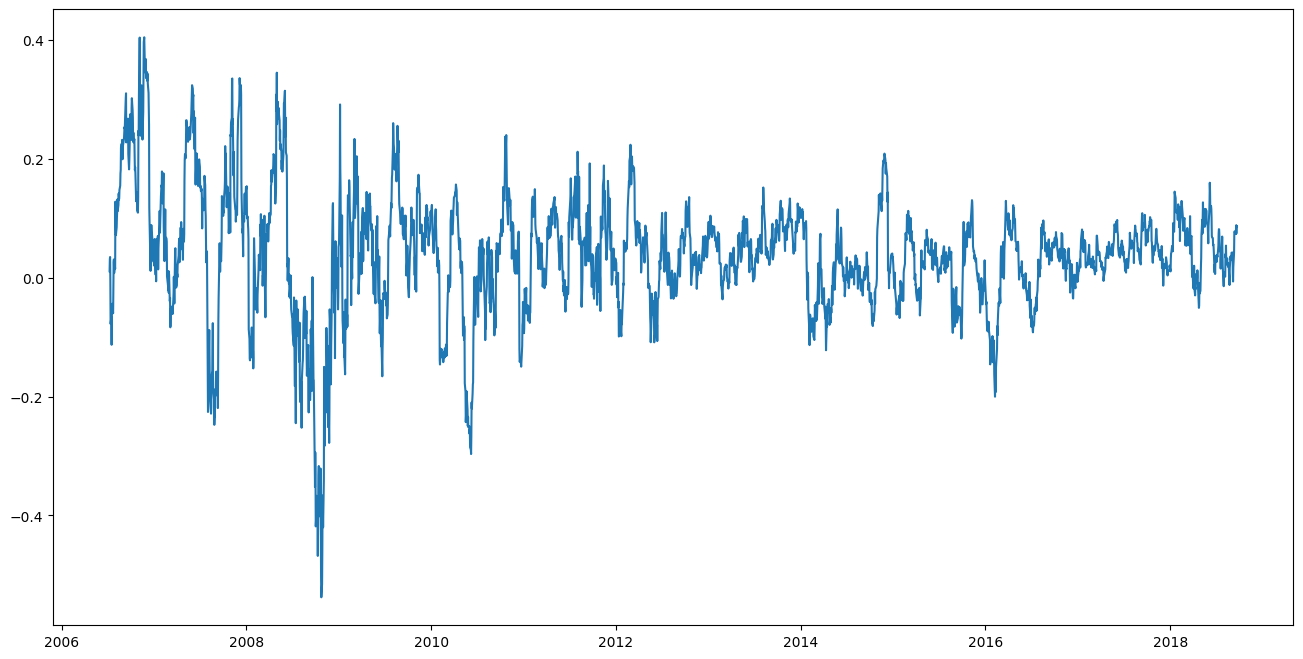

In [7]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import root_mean_squared_error

plt.figure(figsize=(16, 8))
trial = df_train.reset_index()
trial.drop(columns=['Date'], inplace = True)
series_df_train = trial["Close"]
m_AR = AutoReg(series_df_train, lags=415).fit() # p = AR(p = 3)
prediction = m_AR.predict(start=len(df_train), end=len(df_train) + len(df_test)-1, dynamic=False)
plt.plot(df_train)


In [8]:
print(f"series df train: \n{series_df_train.head()}")
print(f"df_test: \n{df_test.head()}")
print(f"prediction: \n{prediction.head()}")
print(f"coefficients: {m_AR.params}")

series df train: 
0    0.010596
1    0.031115
2    0.034621
3   -0.004908
4   -0.077888
Name: Close, dtype: float64
df_test: 
               Close
Date                
2018-09-24  0.088265
2018-09-25  0.093416
2018-09-26  0.086316
2018-09-27  0.104556
2018-09-28  0.089264
prediction: 
3074    0.095971
3075    0.094822
3076    0.087295
3077    0.101354
3078    0.083416
dtype: float64
coefficients: const         0.001623
Close.L1      0.885129
Close.L2      0.080175
Close.L3      0.007889
Close.L4     -0.031203
                ...   
Close.L411    0.028653
Close.L412    0.007764
Close.L413    0.006025
Close.L414   -0.001343
Close.L415   -0.020239
Length: 416, dtype: float64


In [9]:
df_test = df_test.assign(predictions=prediction.values) # stacks series values as a new column to df_test 
df_test

,Close,predictions
Date,,
2018-09-24,0.088265,0.095971
2018-09-25,0.093416,0.094822
2018-09-26,0.086316,0.087295
2018-09-27,0.104556,0.101354
2018-09-28,0.089264,0.083416
...,...,...
2021-10-05,-0.050563,0.024710
2021-10-06,-0.036853,0.024024
2021-10-07,-0.013296,0.024539


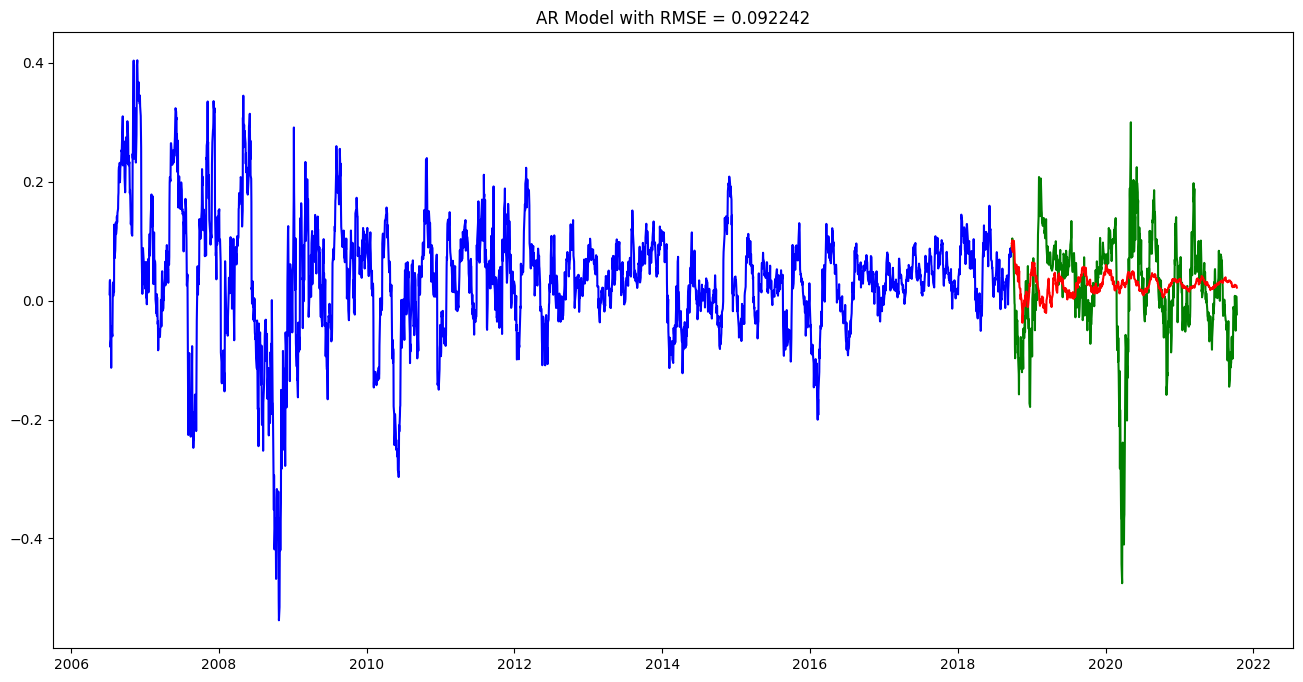

In [10]:
plt.figure(figsize=(16, 8))
plt.title('AR Model with RMSE = %.6f' % root_mean_squared_error(prediction, df_test["Close"]))
plt.plot(df_train, color="blue") # plot df_train
plt.plot(df_test['Close'], color="green") # plot df_test
plt.plot(df_test['predictions'], color="red") # plot our time series predictions

plt.show()

The Auto-Regressive model gives us a RMSE of 0.092242

Let's build the ARIMA model as well and see if we can get a better model

## MA Model

Use moving average to build our model first

0    0.037819
1    0.049625
2    0.080126
3    0.114028
4    0.112685
Name: predicted_mean, dtype: float64


Date
2021-10-05    147.395828
2021-10-06    147.433647
2021-10-07    147.471465
2021-10-08    147.509284
2021-10-11    147.547103
dtype: float64
ARIMA predicted values: Date
2006-07-10    1.491589
2006-07-11    1.503395
2006-07-12    1.533896
2006-07-13    1.567798
2006-07-14    1.566455
dtype: float64


<Figure size 1600x800 with 0 Axes>

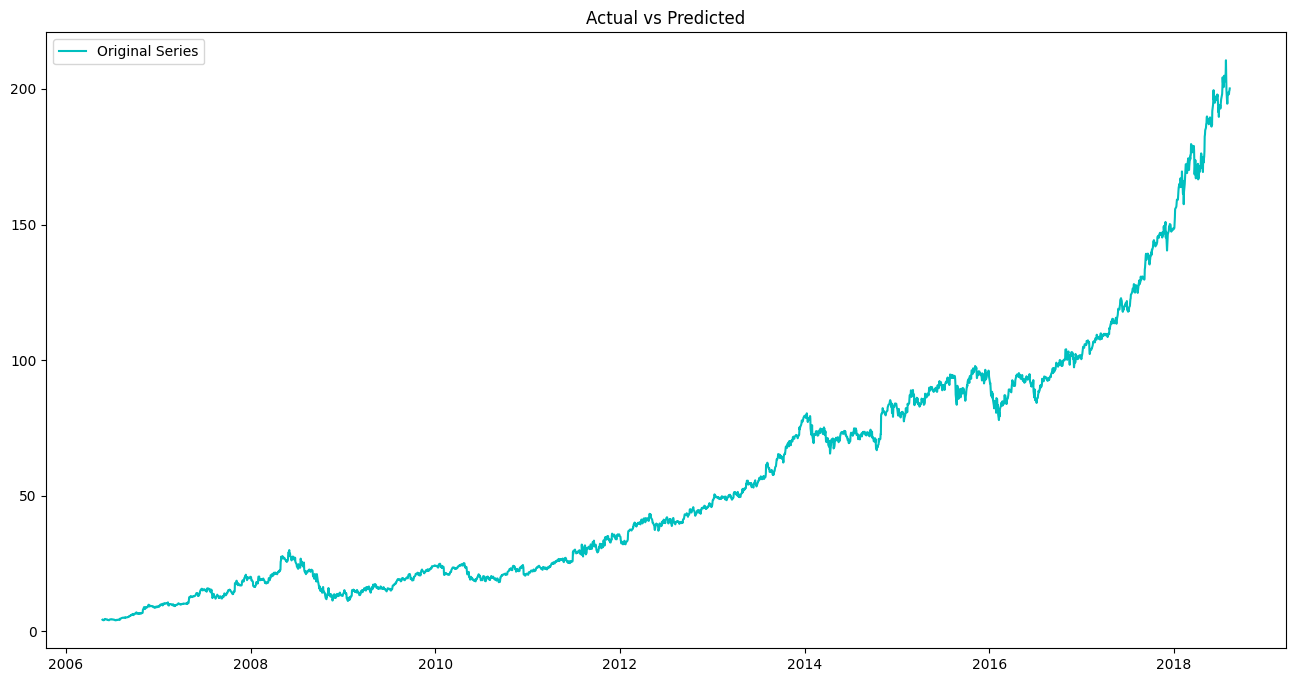

In [68]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
# fits an ARIMA model on (p, d, q) and plots the respective time series.
# Returns the fitted arima model

def arima_routine(p, d, q):
    global df_train, df_shift, df_test, orig_df_train, orig_df_test
    plt.figure(figsize=(16,8))
    m_MA = ARIMA(df_train, order=(p, d, q)).fit() # Using p=0, d=0, q=1 and apply arima function on df_shift series
    prediction = m_MA.predict(end=len(df_train) + len(df_test) - 1)
    df_shift = df_shift.assign(predictions = prediction.values)
    # plt.plot(df_train['Close'])
    # plt.plot(df_test['Close'], color='green')
    # plt.plot(df_shift['predictions'], color='red')
    # # predictions
    # plt.title('MA Model - RMSE: %.4f'% root_mean_squared_error(prediction, df_shift['Close']))
    # plt.show()

    # plot of price against time
    # unshift the data, then exp()

    # do cumulative sum, because we were predicting differences using our model
    predictions_cumsum = prediction.cumsum() # use .cumsum fuction on the predictions
    # Second step - Adding the first value of the log series to the cumulative sum values
    print(predictions_cumsum.head())
    print("\n")
    prediction_arima = pd.Series(predictions_cumsum.to_numpy() + df_log['Close'].iloc[0], index=df_shift.index)
    print(prediction_arima[-5:])

    

    # Third step - applying exponential transformation
    predictions_ARIMA = np.exp(prediction_arima)
    print(f"ARIMA predicted values: {prediction_arima.head()}")
    plt.figure(figsize=(16,8))
    plt.plot(np.exp(orig_df_train), color = 'c', label = 'Original Series')  # plot the original train series
    plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  # plot the predictions ARIMA
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

    return m_MA

arima_routine(1, 0, 3)

## ARIMA Model

In [12]:
arima_routine(30, 0, 3)

KeyboardInterrupt: 

<Figure size 1600x800 with 0 Axes>

c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

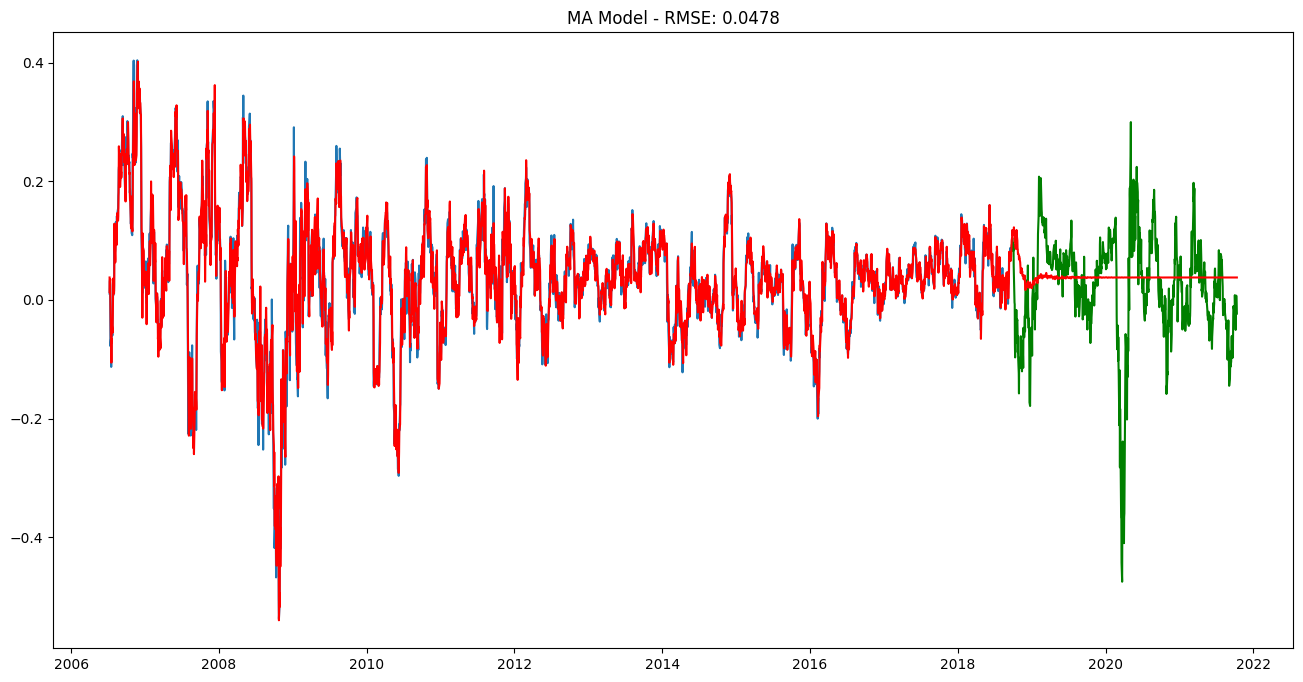

In [ ]:
arima_routine(30, 0, 26)

c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

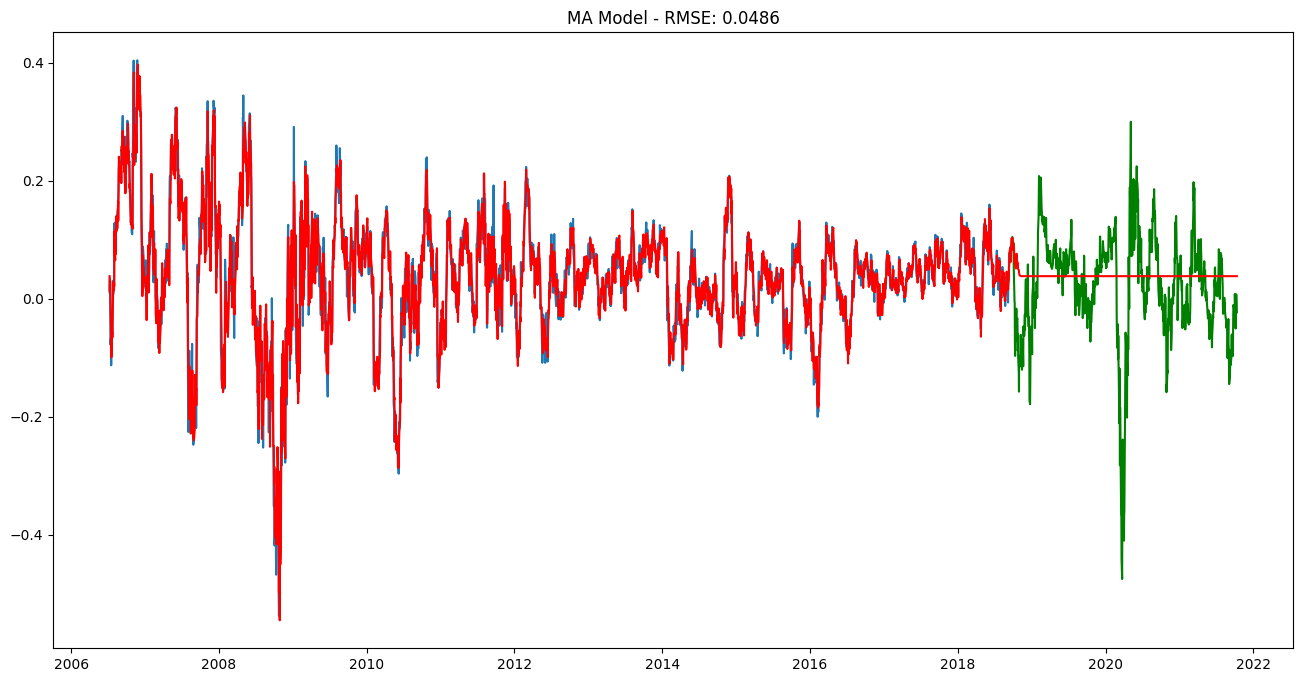

In [ ]:
arima_routine(3, 0, 26)

c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

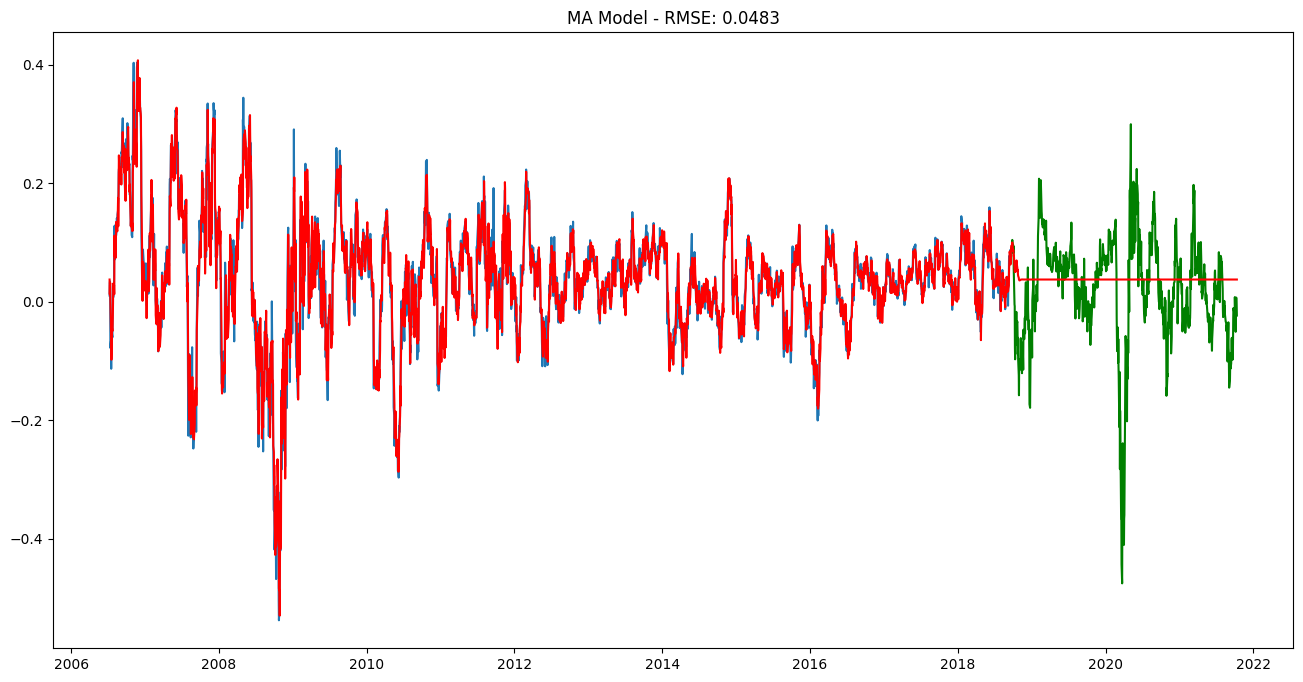

In [ ]:
arima_routine(5, 0 , 26)

c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

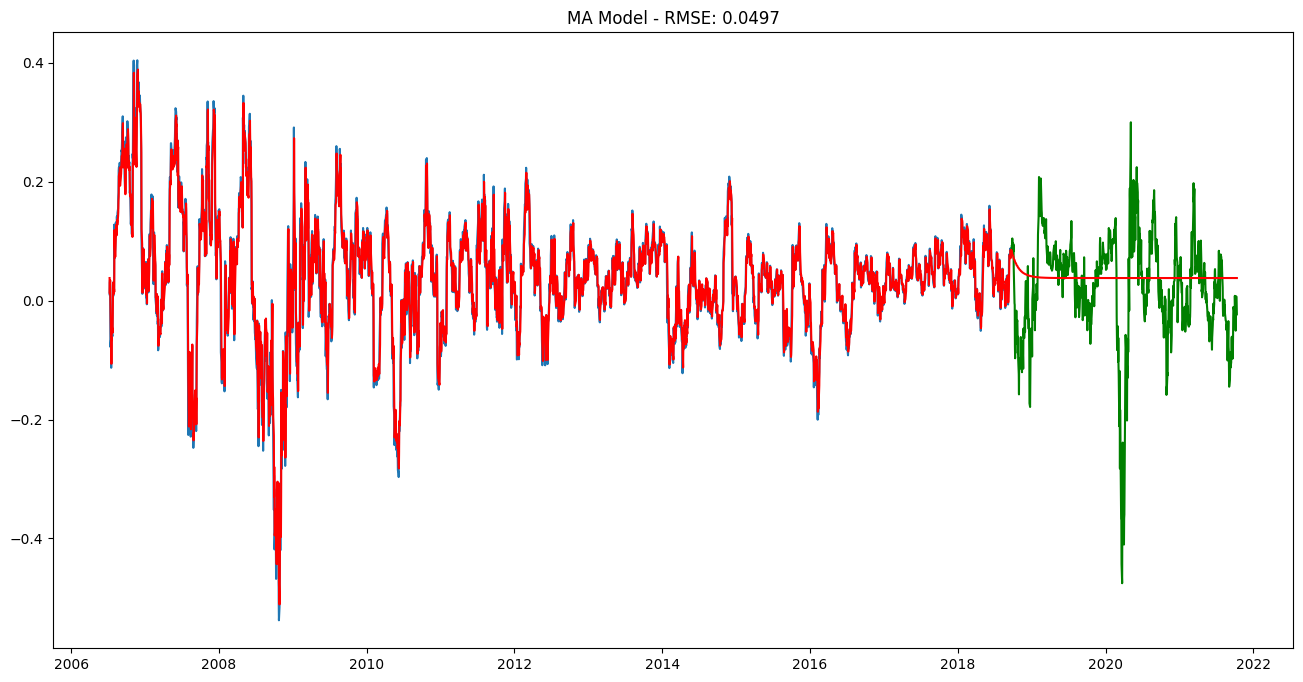

In [ ]:
arima_routine(5, 0, 5)